## imports

In [54]:
# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# data/model helpers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [55]:
# !set when hyperparameter tuning!
import warnings
warnings.filterwarnings('ignore')

## data exploration and cleaning

In [56]:
df = pd.read_csv('data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [58]:
df.Age=df.Age.fillna(value=df.Age.mean())
df.Embarked=df.Embarked.fillna(value='Missing')
df.Embarked=df.Embarked.replace('C','Cherbourg').replace('Q','Queenstown').replace('S','Southampton')
df = df.drop('PassengerId', axis=1)
df = df.drop('Cabin', axis=1)
df = df.drop('Ticket', axis=1)
df = df.drop('Name', axis=1)
df = df.dropna()
y = df.Survived
X = df.drop('Survived',axis=1)

In [59]:
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

#### pre-encoded correlation plot

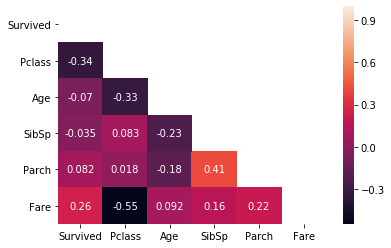

In [60]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, square=False, annot=True)

In [61]:
def encode_and_concat_feature(X, feature_name):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    ohe = OneHotEncoder()
    single_feature_df = X[[feature_name]]
    feature_array = ohe.fit_transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0])
    # drop the old feature from X and concat the new one-hot encoded df
    X = pd.concat([X, ohe_df], axis=1)
#     X = X.drop(f'{feature_name}', axis=1)
    return X

#### encoding categorical features

In [62]:
X = encode_and_concat_feature(X,'Pclass')
for i in [1,2,3]:
    X.rename(columns={i:f'Pclass: {i}'},inplace=True)
X.drop('Pclass',axis=1,inplace=True)
X = encode_and_concat_feature(X,'Sex')
X.drop('Sex',axis=1,inplace=True)
X = encode_and_concat_feature(X,'SibSp')
for i in range(9):
    X.rename(columns={i:f'SibSp: {i}'},inplace=True)
X.drop('SibSp',axis=1,inplace=True)
X = encode_and_concat_feature(X,'Parch')
for i in range(7):
    X.rename(columns={i:f'Parch: {i}'},inplace=True)
X.drop('Parch',axis=1,inplace=True)
X = encode_and_concat_feature(X,'Embarked')
X.drop('Embarked',axis=1,inplace=True)
# attempting to drop fare to see if its colinearity with Pclass is having adverse effects
X.drop('Fare',axis=1,inplace=True)

#### scaling numeric data

In [63]:
# numeric_features = X[['Age','Fare']]

# ss = StandardScaler()
# numeric_features = ss.fit_transform(numeric_features)
# X = pd.concat([pd.DataFrame(numeric_features),X.drop(['Age','Fare'],axis=1)],axis=1)
# X = X.rename({0:'Age',1:'Fare'},axis=1)

# attempting to drop fare to see if its colinearity with Pclass is having adverse effects
numeric_features = np.array(X['Age']).reshape(-1, 1)

ss = StandardScaler()
numeric_features = ss.fit_transform(numeric_features)
X = pd.concat([pd.DataFrame(numeric_features),X.drop('Age',axis=1)],axis=1)
X = X.rename({0:'Age'},axis=1)

## exploring correlations

In [66]:
df = pd.concat([pd.DataFrame(y),X],axis=1)

In [67]:
corr = df.corr()
# Generate a mask for the upper triangle
s = corr.unstack()
so = s.sort_values(kind="quicksort")
indices = so.index
l = len(so)
survived_corr = []
for i in range(l):
    row = so[i]
    if 'Survived' in indices[i]:
        survived_corr.append((indices[i],row))
survived_corr = [(a,b) for (a,b) in survived_corr if a[0]=='Survived']
pd.DataFrame(survived_corr,columns=['CorrelationPair','CorrelationCoefficient'])

,CorrelationPair,CorrelationCoefficient
0,"(Survived, male)",-0.543351
1,"(Survived, Pclass: 3)",-0.322308
2,"(Survived, Southampton)",-0.155660
3,"(Survived, Parch: 0)",-0.147408
4,"(Survived, SibSp: 0)",-0.115867
5,"(Survived, SibSp: 8)",-0.070234
6,"(Survived, Age)",-0.069809
7,"(Survived, SibSp: 4)",-0.064123
8,"(Survived, SibSp: 5)",-0.059292
9,"(Survived, Parch: 4)",-0.053002


#### train_test_split for modeling

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

## LogisticRegression

In [69]:
log = LogisticRegression(random_state=42)
log.fit(X_train,y_train)
log_cvs = cross_val_score(log,X_test,y_test)

In [70]:
print(log_cvs)
print('avg: ',np.mean(log_cvs))

[0.75925926 0.77777778 0.83333333 0.88679245 0.69811321]
avg:  0.7910552061495458


## RandomForestClassifier


In [71]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train,y_train)
rfc_cvs = cross_val_score(rfc,X_test,y_test) 

In [72]:
print(rfc_cvs)
print('avg: ',np.mean(rfc_cvs))

[0.7962963  0.7962963  0.7962963  0.71698113 0.8490566 ]
avg:  0.7909853249475891


## KNeighborsClassifier

In [73]:
knc = KNeighborsClassifier()
knc.fit(X_train,y_train)
knc_cvs = cross_val_score(knc,X_test,y_test)

In [74]:
print(knc_cvs)
print('avg: ',np.mean(knc_cvs))

[0.77777778 0.77777778 0.7962963  0.73584906 0.73584906]
avg:  0.7647099930118799


## XGBoost

In [75]:
XGBRFC = XGBRFClassifier(random_state=42)
XGBRFC.fit(X_train, y_train)
XGB_cvs = cross_val_score(XGBRFC,X_test,y_test)

In [76]:
print(XGB_cvs)
print('avg: ',np.mean(XGB_cvs))

[0.7962963  0.7962963  0.87037037 0.83018868 0.71698113]
avg:  0.8020265548567436


## VotingClassifier

In [77]:
log = LogisticRegression(random_state=42)
rfc = RandomForestClassifier(random_state=42)
knc = KNeighborsClassifier()
XGBRFC = XGBRFClassifier(random_state=42)
# KN was not adding to accuracy of model
models = [('log',log),('rf',rfc),('XGBoost',XGBRFC)]

In [78]:
voter = VotingClassifier(estimators=models,voting='soft')
voter.fit(X_train,y_train)
voter.score(X_test,y_test)

0.7985074626865671

## GridSearchCV for hyperparameter tuning

#### LogisticRegression

In [79]:
logit = LogisticRegression(random_state=42)
params = {
    'penalty': ('l1', 'l2', 'elasticnet'),
    'C': [1.0,.1,.01],
    'solver': ('lbfgs', 'liblinear'),
    'n_jobs':[1,2,5],
    'tol': [1e-2,1e-3,1e-4]
}
logit_gs = GridSearchCV(logit,params)
logit_gs.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1.0, 0.1, 0.01], 'n_jobs': [1, 2, 5],
                         'penalty': ('l1', 'l2', 'elasticnet'),
                         'solver': ('lbfgs', 'liblinear'),
                         'tol': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, 

In [80]:
logit_gs.best_params_

{'C': 1.0, 'n_jobs': 1, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}

In [81]:
logit = LogisticRegression(penalty='l1',solver='liblinear',tol=1e-3,random_state=42)
logit.fit(X_train,y_train)
csv = cross_val_score(logit,X_test,y_test)
print(csv)
print(np.mean(csv))

[0.75925926 0.7962963  0.81481481 0.88679245 0.73584906]
0.7986023759608665


#### RandomForestClassifier

In [28]:
rfc = RandomForestClassifier(random_state=42)
params = {
    'n_estimators':[10,100,500],
    'criterion':('gini','entropy'),
    'min_samples_split':[2,3,4],
    'max_features':('auto','sqrt','log2')   
}
rfc_gs = GridSearchCV(rfc,params)
rfc_gs.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                               

In [29]:
rfc_gs.best_params_

{'criterion': 'entropy',
 'max_features': 'auto',
 'min_samples_split': 4,
 'n_estimators': 100}

In [82]:
rfc = RandomForestClassifier(random_state=42,criterion='entropy',min_samples_split=4)
rfc.fit(X_train,y_train)
cvs = cross_val_score(rfc,X_test,y_test)
print(cvs)
print(np.mean(cvs))

[0.83333333 0.77777778 0.7962963  0.77358491 0.8490566 ]
0.806009783368274


#### KNeighborsClassifier

In [31]:
knc = KNeighborsClassifier()
params = {
    'leaf_size':range(1,50),
    'n_neighbors':range(1,30),
    'p':[1,2]
}
knc_gs = GridSearchCV(knc,params)
knc_gs.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'leaf_size': range(1, 50), 'n_neighbors': range(1, 30),
                         'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [32]:
knc_gs.best_params_

{'leaf_size': 1, 'n_neighbors': 13, 'p': 2}

In [83]:
knc = KNeighborsClassifier(leaf_size=1,n_neighbors=13,p=2)
knc.fit(X_train,y_train)
cvs = cross_val_score(knc,X_test,y_test)
print(cvs)
print(np.mean(cvs))

[0.77777778 0.7962963  0.87037037 0.77358491 0.77358491]
0.7983228511530398


## HP tuned VotingClassifier

In [84]:
models = [('log',logit),('rf',rfc),('knn',knc),('XGBoost',XGBRFC)]
tuned_voter = VotingClassifier(estimators=models,voting='hard')
tuned_voter.fit(X_train,y_train)

VotingClassifier(estimators=[('log',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [85]:
tuned_voter.score(X_test,y_test)

0.7985074626865671

Looks like the tuned voter is performing worse than untuned 

In [86]:
len(df)

891